# **Intro linear latent space arithmetic PCA**
In this notebook I use a PCA in order to predict the gene expression changes induced by a perturbation.
Here, we want to know the cell-type specific perturbation effect.
We use unperturbed single-cell and pert+unpert bulk in order to infer the cell-type specific expressiom change.
To do this, we use latent space arithmetic, where the latent space is the PCA space. 





# **Imports**

In [1]:
# general imports
import warnings
import numpy as np
import scanpy as sc
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)

<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../buddi/plotting/validation_plotting.py'>

In [40]:
## parameters
aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../../results/single_cell_data/PCA_kang/"
cibersort_genes_path = (f"{os.getcwd()}/../../results/single_cell_data/cibersort_kang/" +
                        "CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt")

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../../results/single_cell_data/cibersort_kang/CIBERSORTx_Job22_Results.csv"
cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_kang/"

# bp results
bp_res_path = f"{os.getcwd()}/../../results/single_cell_data/bp_kang/"

# DiffExp results
de_res_path = f"{os.getcwd()}/../../data/single_cell_data/kang_rybakov/kang_DE_paper.tsv"

num_genes = 7000

exp_id = "mono-kang"

RETRAIN_MODELS = False

# Set-up experimental variables

In [4]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8


# number of patients/domains/samples expected
n_tot_samples = 8 # 8 bulk and single cell samples

# number of drugs one-hot encoded
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [5]:
# read in the labeled data
X_full, Y_full, gene_df, meta_df = sc_preprocess.read_all_kang_pseudobulk_files(aug_data_path, exp_id, num_bulks_training=10)
X_full.columns = gene_df


1488
STIM
Train
Test
CTRL
Train
Test
1244
STIM
Train
Test
CTRL
Train
Test
1016
STIM
Train
Test
CTRL
Train
Test
101
STIM
Train
Test
CTRL
Train
Test
1039
STIM
Train
Test
CTRL
Train
Test
107
STIM
Train
Test
CTRL
Train
Test


In [6]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train_df = X_train_df[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6928)[-6928:]
gene_df = gene_df.iloc[idx_top]


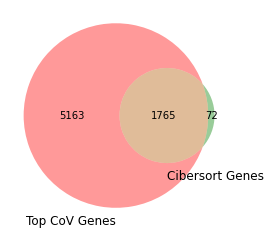

In [7]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [8]:
union_genes = np.union1d(gene_df, cibersort_genes)


# Normalize data

In [9]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


X_cvae = X_full[idx_train,]
label_cvae = label_full[idx_train,]
bulk_cvae = bulk_full[idx_train,]
drug_cvae = drug_full[idx_train,]
y_cvae = Y_full.iloc[idx_train,]




# Plot all data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 17320 samples in 0.100s...
[t-SNE] Computed neighbors for 17320 samples in 24.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17320
[t-SNE] Computed conditional probabilities for sample 2000 / 17320
[t-SNE] Computed conditional probabilities for sample 3000 / 17320
[t-SNE] Computed conditional probabilities for sample 4000 / 17320
[t-SNE] Computed conditional probabilities for sample 5000 / 17320
[t-SNE] Computed conditional probabilities for sample 6000 / 17320
[t-SNE] Computed conditional probabilities for sample 7000 / 17320
[t-SNE] Computed conditional probabilities for sample 8000 / 17320
[t-SNE] Computed conditional probabilities for sample 9000 / 17320
[t-SNE] Computed conditional probabilities for sample 10000 / 17320
[t-SNE] Computed conditional probabilities for sample 11000 / 17320
[t-SNE] Computed conditional probabilities for sample 12000 / 17320
[t-SNE] Computed conditional probabilities for sa

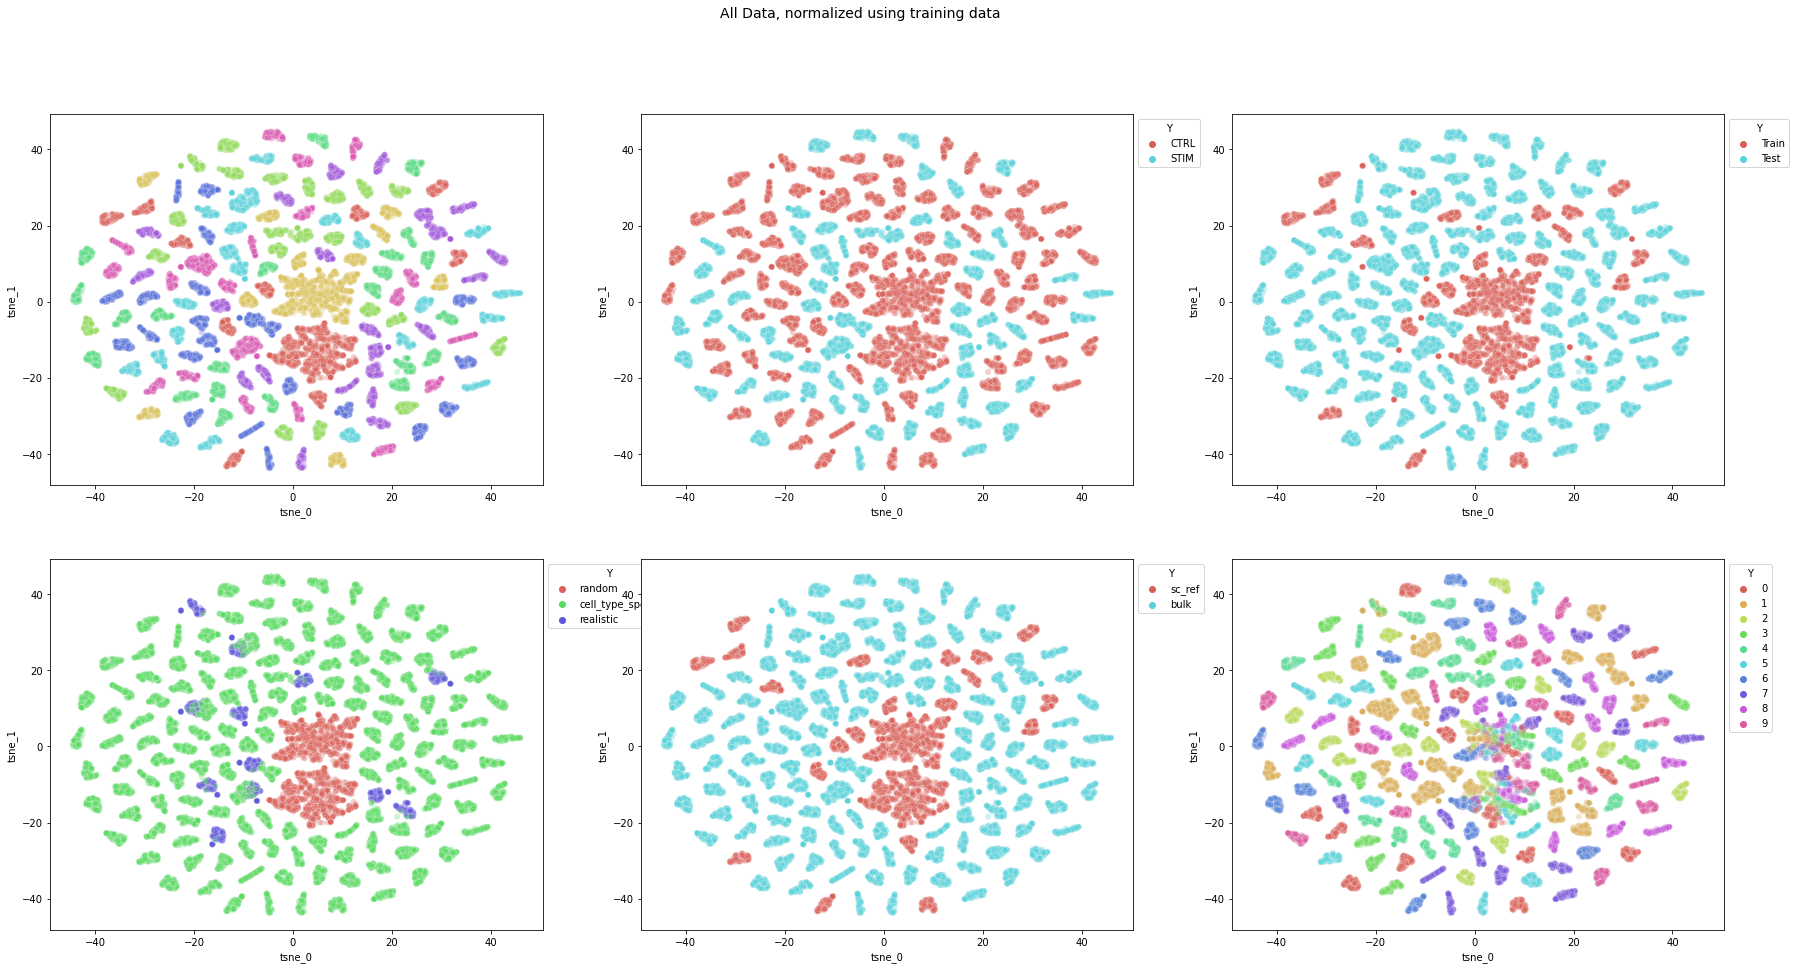

In [10]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **PCA Model Definition**

In [11]:
len(np.where(np.logical_and(meta_df.isTraining=="Train", meta_df.samp_type != "bulk"))[0] )

4000

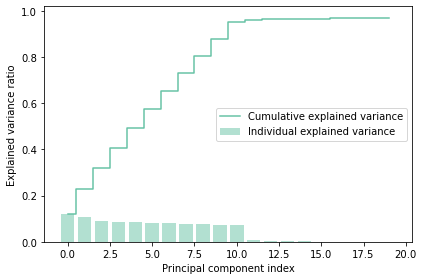

In [12]:
### get training data

idx_bulk_train = np.where(np.logical_and(meta_df.isTraining=="Train", meta_df.samp_type == "bulk"))[0] 
X_temp = X_full[idx_bulk_train]

fit = PCA(n_components=20)
pca_results = fit.fit_transform(X_temp)

exp_var_pca = fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

## plot variance explained
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

## Plot Reconstruction

In [13]:
Label_full.shape

(17320,)

In [14]:

X_temp = np.copy(X_full)


label_temp = np.copy(label_full)
perturb_temp = drug_full

recon_idx = np.where(meta_df.isTraining == "Train")[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)


Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)

X_temp = X_temp[recon_idx]
label_temp = label_temp[recon_idx]
perturb_temp = perturb_temp[recon_idx]
label_num = np.copy(Label_full)
label_num = label_num[recon_idx]

# now use the PCA to get the latent space
pca_proj = fit.transform(X_temp)
decoded_outputs = fit.inverse_transform(pca_proj)


(10000, 2)
(10000, 2)


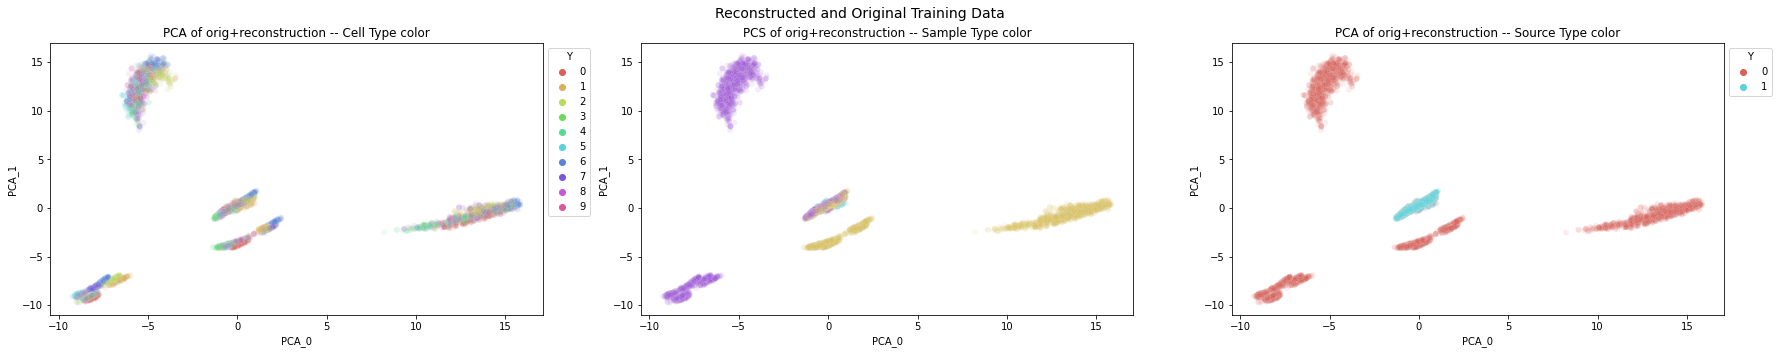

In [15]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])



Y_dup = np.append(Y_temp, Y_temp)


label_dup = np.append(label_num, label_num)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*len(perturb_temp), [1]*len(perturb_temp)))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed and Original Training Data", fontsize=14)
axs[1].legend([],[], frameon=False)

fig.show()

In [16]:

X_temp = np.copy(X_full)


label_temp = np.copy(label_full)
perturb_temp = drug_full
bulk_temp = bulk_full

recon_idx = np.where(meta_df.isTraining == "Test")[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)

Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)

X_temp = X_temp[recon_idx]
label_temp = label_temp[recon_idx]
perturb_temp = perturb_temp[recon_idx]
label_num = np.copy(Label_full)
label_num = label_num[recon_idx]

# now use the PCA to get the latent space
pca_proj = fit.transform(X_temp)
decoded_outputs = fit.inverse_transform(pca_proj)


(10000, 2)
(10000, 2)


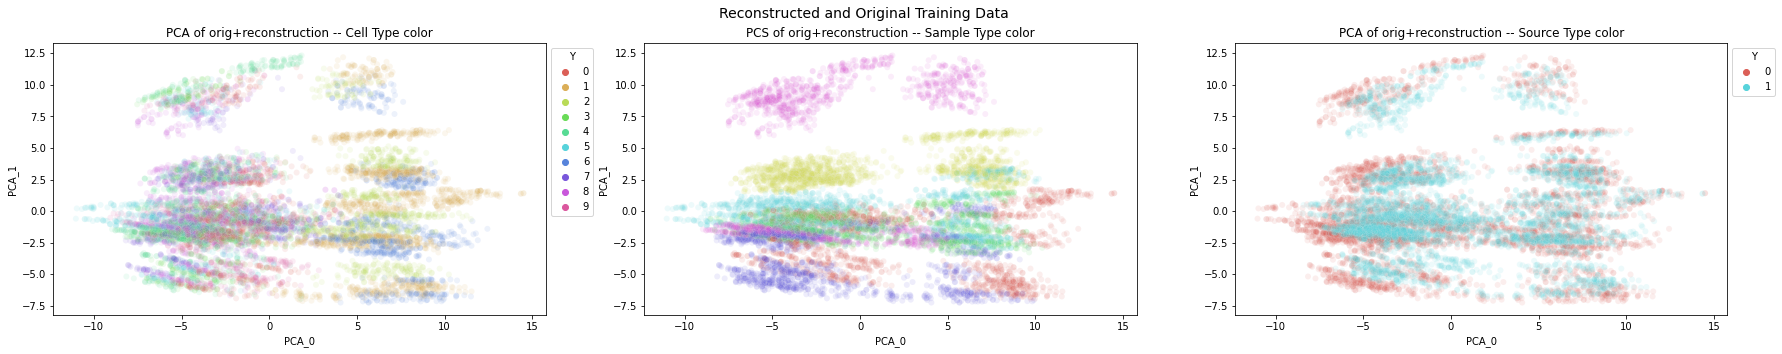

In [17]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])



Y_dup = np.append(Y_temp, Y_temp)


label_dup = np.append(label_num, label_num)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*len(perturb_temp), [1]*len(perturb_temp)))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed and Original Training Data", fontsize=14)
axs[1].legend([],[], frameon=False)

fig.show()

(5000, 2)
(5000, 2)


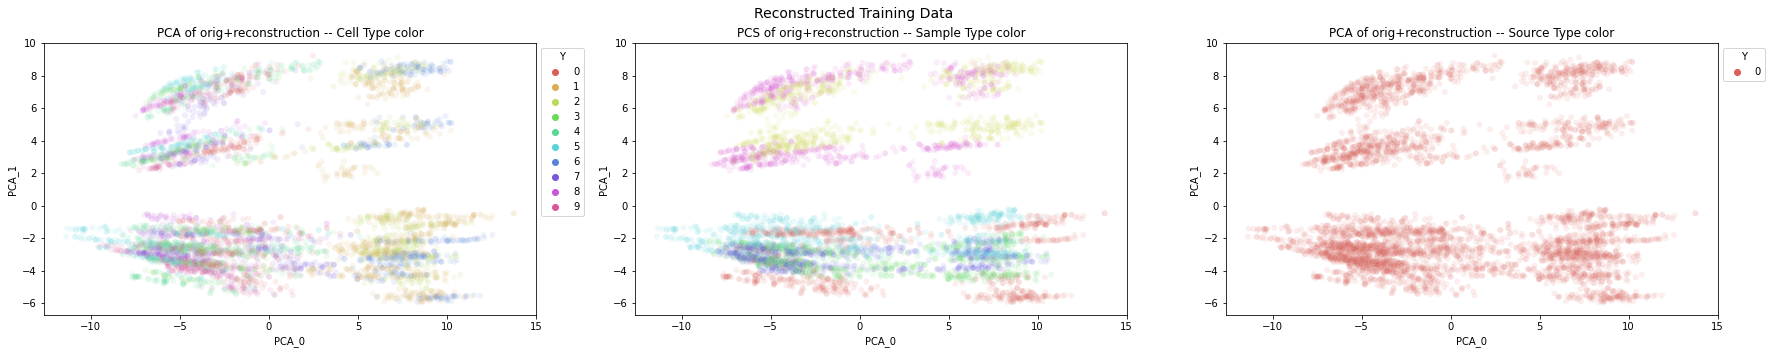

In [18]:

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(X_temp))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_num, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=[0]*len(perturb_temp), ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed Training Data", fontsize=14)
axs[1].legend([],[], frameon=False)

fig.show()

(5000, 2)
(5000, 2)


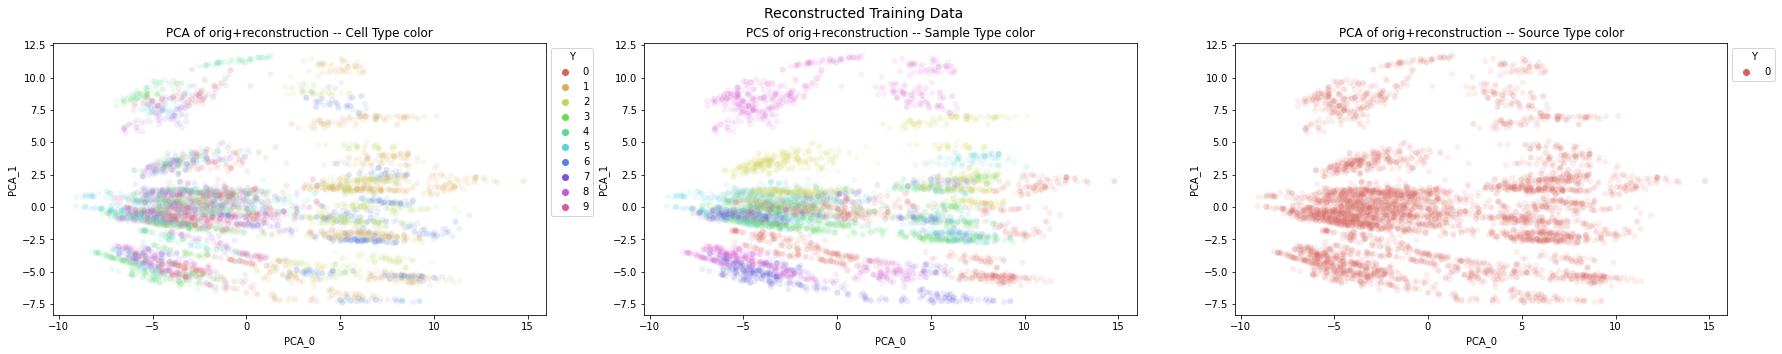

In [19]:

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = vp.get_pca_for_plotting(np.asarray(decoded_outputs))
vp.plot_pca(plot_df, color_vec=Y_temp, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_num, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
vp.plot_pca(plot_df, color_vec=[0]*len(perturb_temp), ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")



fig.suptitle("Reconstructed Training Data", fontsize=14)
axs[1].legend([],[], frameon=False)

fig.show()

In [20]:
X_temp

array([[0.        , 0.0154321 , 0.        , ..., 0.11893204, 0.04935275,
        0.        ],
       [0.        , 0.00231481, 0.        , ..., 0.00849515, 0.00161812,
        0.0085796 ],
       [0.        , 0.        , 0.        , ..., 0.58495146, 0.0157767 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.19134304, 0.        ,
        0.19542421],
       [0.        , 0.        , 0.        , ..., 0.0776699 , 0.        ,
        0.01143947],
       [0.        , 0.        , 0.        , ..., 0.43122977, 0.02710356,
        0.        ]])

In [21]:
decoded_outputs

array([[-9.91528365e-05, -6.91990819e-03,  3.36371433e-04, ...,
         2.06780402e-01,  2.52332194e-01,  1.61150077e-02],
       [ 6.12324736e-04, -3.13314898e-03,  3.39432601e-02, ...,
         6.48090223e-02,  3.44477789e-02,  4.61765816e-02],
       [ 7.97913020e-04,  2.98570519e-02,  1.18697622e-02, ...,
         2.98172072e-01,  1.66009329e-01,  2.31046771e-02],
       ...,
       [ 4.40343880e-04, -1.87935772e-02, -2.14823628e-03, ...,
         3.30477957e-01,  2.51853947e-02,  1.81694235e-02],
       [ 1.42890533e-04,  2.43229239e-03,  1.39533985e-02, ...,
         8.98494197e-03,  3.49302659e-02,  2.24379110e-02],
       [ 4.32490932e-04,  8.95044498e-02,  1.69628431e-03, ...,
         4.92966092e-01,  1.10450222e-02,  2.05068136e-02]])

## Do latent space projectsions

### drug perturbation

In [42]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)


<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../buddi/plotting/validation_plotting.py'>

In [25]:



res_meta_df, decoded_0_0, decoded_0_1 = calc_PCA_perturbation(X_full, meta_df, scaler, fit)
decoded_0_1 = np.clip(decoded_0_1, 0, clip_upper)
decoded_0_0 = np.clip(decoded_0_0, 0, clip_upper)


In [34]:

# run first the cell_type specific things

cell_type_specific_r2 = None
cell_type_specific_real = None
cell_type_specific_proj = None
meta_DESeq = None
all_samps = ['101', '1016', '1039', '107', '1244', '1488']


sc_proj_meta_df, decoded_0_0, decoded_0_1 = vp.calc_PCA_perturbation(X_full, meta_df, scaler, fit)
decoded_0_1 = np.clip(decoded_0_1, 0, clip_upper)
decoded_0_0 = np.clip(decoded_0_0, 0, clip_upper)

for curr_samp in all_samps:
    print(curr_samp)
    for curr_cell_type in Y_full.columns:
        print(curr_cell_type)

        real_stim, real_ctrl, proj_stim, proj_ctrl = vp.subset_sample_celltype_perturbation(X_full, decoded_0_0, 
                                                                                        decoded_0_1, scaler, curr_samp, 
                                                                                        "cell_type_specific", 
                                                                                        meta_df, sc_proj_meta_df,
                                                                                        curr_cell_type)

        expr_r2_stim, expr_r2_ctrl, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse, expr_stim_rmse, expr_ctrl_rmse = vp.calc_expr_log2FC_r2(real_ctrl, real_stim, proj_ctrl, proj_stim)

        curr_res = [curr_samp, curr_cell_type, "cell_type_specific", expr_r2_stim,
                    expr_r2_ctrl, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, 
                    log2FC_r2_top, log2FC_rmse, expr_stim_rmse, expr_ctrl_rmse]
        curr_res = pd.DataFrame([curr_res],  columns = ['sample_id', 'cell_type', 'bulk_type', 
                                                        'expr_r2_stim', 'expr_r2_ctrl', 'log2FC_r2',
                                                        'log2FC_r2_bottom', 'log2FC_r2_mid', 'log2FC_r2_top', 'log2FC_rmse',
                                                        'expr_stim_rmse', 'expr_ctrl_rmse'])

        curr_meta_real = {'sample_id':[curr_samp]*(real_ctrl.shape[0]+ real_stim.shape[0]),
                        'cell_type':[curr_cell_type]*(real_ctrl.shape[0]+ real_stim.shape[0]),
                        'cond':['ctrl']*(real_ctrl.shape[0]) + ['stim']*(real_stim.shape[0])}
        curr_meta_real = pd.DataFrame(curr_meta_real)

        curr_meta_proj = {'sample_id':[curr_samp]*(proj_ctrl.shape[0]+ proj_stim.shape[0]),
                        'cell_type':[curr_cell_type]*(proj_ctrl.shape[0]+ proj_stim.shape[0]),
                        'cond':['ctrl']*(proj_ctrl.shape[0]) + ['stim']*(proj_stim.shape[0])}
        curr_meta_proj = pd.DataFrame(curr_meta_proj)
        
        curr_DESeq_real = np.append(real_ctrl, real_stim, axis=0)
        curr_DESeq_proj = np.append(proj_ctrl, proj_stim, axis=0)

        if cell_type_specific_r2 is None:
            cell_type_specific_r2 = curr_res
            meta_DESeq_real = curr_meta_real
            meta_DESeq_proj = curr_meta_proj
            cell_type_specific_real = curr_DESeq_real
            cell_type_specific_proj = curr_DESeq_proj
        else:
            cell_type_specific_r2 = pd.concat([cell_type_specific_r2, curr_res])
            meta_DESeq_real = pd.concat([meta_DESeq_real, curr_meta_real])
            meta_DESeq_proj = pd.concat([meta_DESeq_proj, curr_meta_proj])
            cell_type_specific_real = np.append(cell_type_specific_real, curr_DESeq_real, axis=0)
            cell_type_specific_proj = np.append(cell_type_specific_proj, curr_DESeq_proj, axis=0)




# now run the realistic ones

/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../buddi/plotting/validation_plotting.py:309: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_meta_df = final_meta_df.append(curr_meta_df)
/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../buddi/plotting/validation_plotting.py:309: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_meta_df = final_meta_df.append(curr_meta_df)
/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../buddi/plotting/validation_plotting.py:309: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_meta_df = final_meta_df.append(curr_meta_df)
/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_compara

101
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1016
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1039
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
107
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1244
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1488
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act


In [35]:
cell_type_specific_r2

,sample_id,cell_type,bulk_type,expr_r2_stim,expr_r2_ctrl,log2FC_r2,log2FC_r2_bottom,log2FC_r2_mid,log2FC_r2_top,log2FC_rmse,expr_stim_rmse,expr_ctrl_rmse
0,101,B,cell_type_specific,0.518419,0.400389,0.715048,0.625759,0.743405,0.654456,2.358290,725.702880,839.301295
0,101,CD14_Mono,cell_type_specific,0.586870,0.384828,0.594028,0.428170,0.634176,0.593517,3.037533,615.354950,838.673127
0,101,CD16_Mono,cell_type_specific,0.545738,0.421815,0.713950,0.621170,0.769603,0.641685,2.352800,691.045993,852.082888
0,101,CD4_Mem_T,cell_type_specific,0.518401,0.384692,0.707426,0.586102,0.750603,0.659968,2.424407,687.461102,776.811870
0,101,CD4_Naive_T,cell_type_specific,0.497790,0.363341,0.696782,0.584665,0.736225,0.650292,2.432246,825.336734,818.860419
0,101,CD8_T,cell_type_specific,0.507715,0.398161,0.707165,0.600261,0.720601,0.701796,2.414535,751.022663,816.619131
0,101,DC,cell_type_specific,0.543601,0.477349,0.711644,0.633009,0.752559,0.653531,2.359039,801.649258,927.188031
0,101,Mk,cell_type_specific,0.546325,0.417399,0.715912,0.620293,0.754401,0.654528,2.378398,892.796066,834.128036
0,101,NK,cell_type_specific,0.496450,0.376824,0.702477,0.599816,0.706450,0.707702,2.431980,769.608329,834.775183
0,101,T_Act,cell_type_specific,0.505126,0.411042,0.705396,0.610285,0.738803,0.661299,2.384863,788.867367,895.235727


In [41]:
pearson_res_file = os.path.join(res_data_path, f"{exp_id}_pearson_PCA.csv")
cell_type_specific_r2.to_csv(pearson_res_file, index=False)

(12000, 2)
(12000, 2)


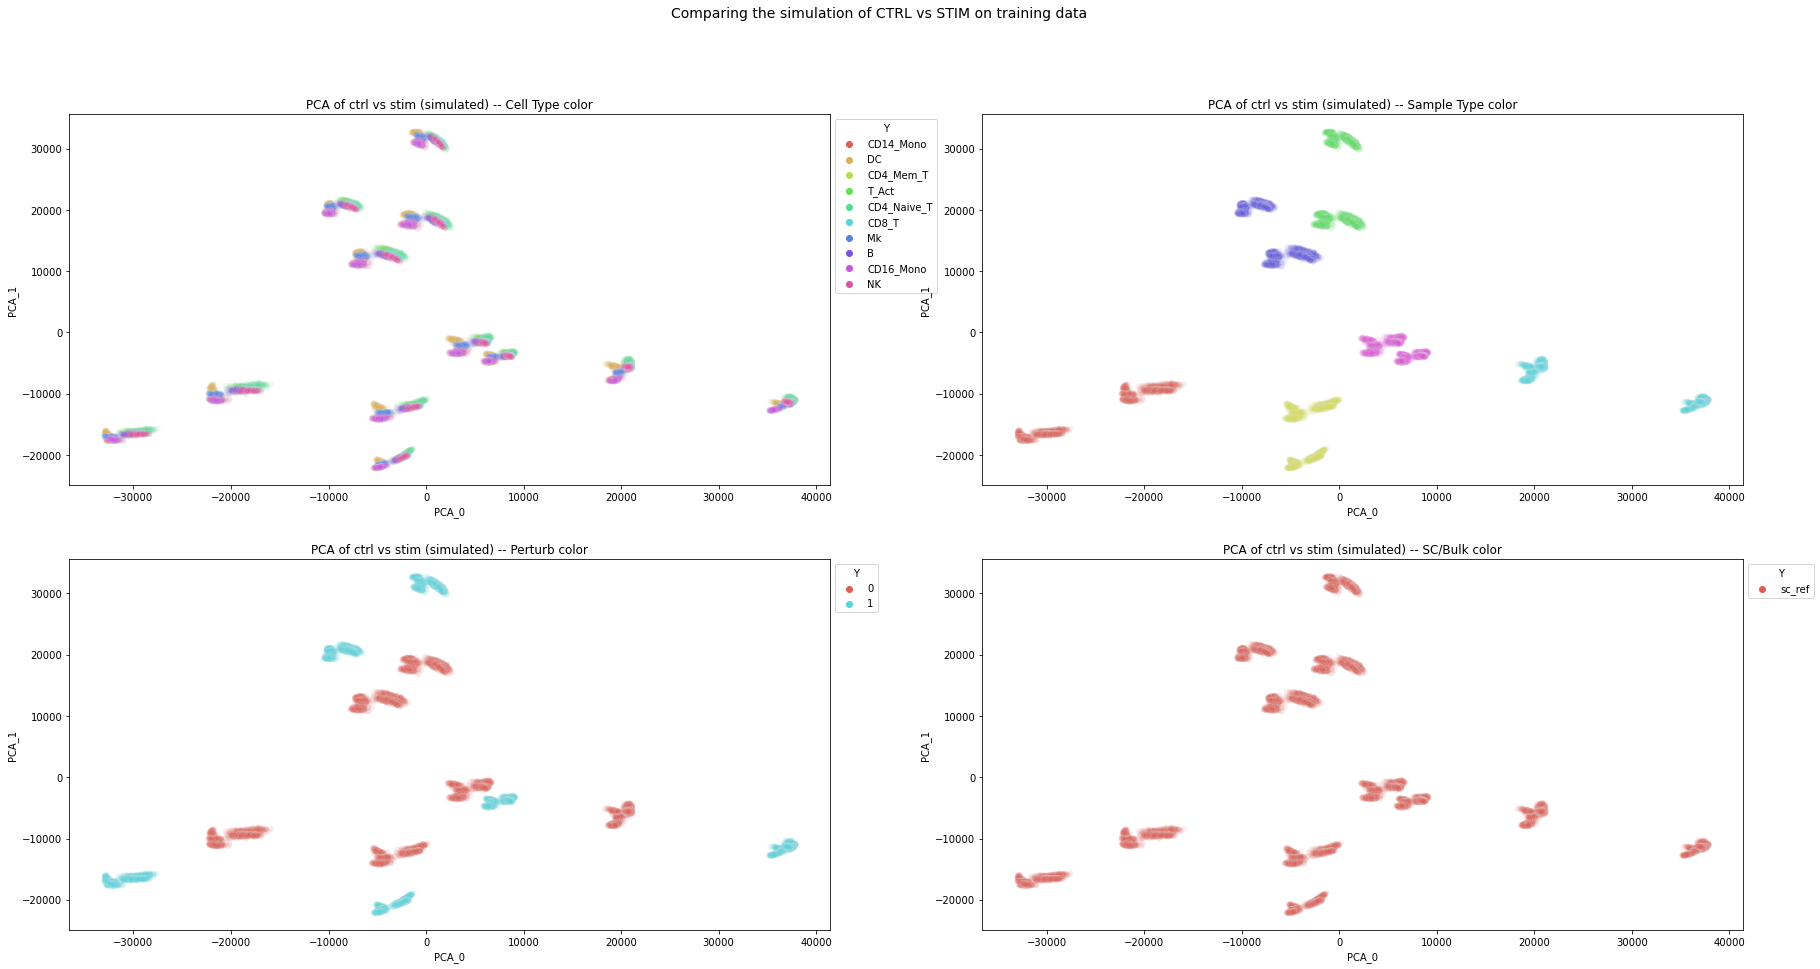

In [39]:
# make duplicated
X_dup = np.vstack([decoded_0_0, decoded_0_1])


Y_dup = np.append(sc_proj_meta_df.Y_max, sc_proj_meta_df.Y_max)


label_dup = np.append(sc_proj_meta_df.sample_id, sc_proj_meta_df.sample_id)

n_row_temp = sc_proj_meta_df.shape[0]
perturb_dup = np.asarray(np.append([0]*n_row_temp, [1]*n_row_temp))
source_dup = np.append(sc_proj_meta_df.samp_type, sc_proj_meta_df.samp_type)

fig, axs = plt.subplots(2, 2, figsize=(30,15))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0,0], title="PCA of ctrl vs stim (simulated) -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[0,1], title="PCA of ctrl vs stim (simulated) -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_dup, ax=axs[1,0], title="PCA of ctrl vs stim (simulated) -- Perturb color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[1,1], title="PCA of ctrl vs stim (simulated) -- SC/Bulk color")



fig.suptitle("Comparing the simulation of CTRL vs STIM on training data", fontsize=14)
axs[0,1].legend([],[], frameon=False)

fig.show()

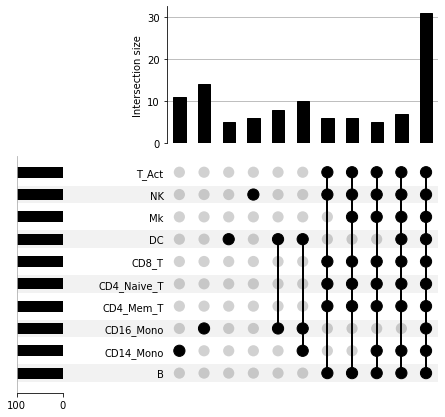

In [27]:
from scipy.stats import rankdata


top_lim = 100

top_genes = {}
de_genes_all = None
for curr_cell_type in Y_full.columns:


    # this is for the "projected" expression
    curr_idx = np.where(res_meta_df.Y_max == curr_cell_type)[0]
    proj_ctrl = decoded_0_0[curr_idx]
    proj_stim = decoded_0_1[curr_idx]

    # take the median for nomalization

    proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
    proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
    #proj_ctrl = np.median(proj_ctrl, axis=0)
    #proj_stim = np.median(proj_stim, axis=0)
    proj_log2FC = np.abs(proj_stim-proj_ctrl)

    # make into DF
    proj_log2FC_df = pd.DataFrame(proj_log2FC, index=union_genes)

    intersect_proj = proj_log2FC_df.loc[union_genes][0]
    top_proj_genes = intersect_proj.index[np.argsort(np.abs(intersect_proj))].tolist()[::-1][0:top_lim]

    top_genes[curr_cell_type] = top_proj_genes


cell_diff = from_contents(top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()

#venn2([set(top_pub_genes), set(top_proj_genes)], set_labels = ('Top Pub Genes', 'Top Proj Genes'))
#plt.show()


In [34]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

def plot_effect_size_corr(xval, yval, ax, title, xlab, ylab, class_id, style_id, alpha=0.5):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id,
        alpha= alpha,
        style=style_id
    )
    #g.set(ylim=(min_val, max_val))
    #g.set(xlim=(min_val, max_val))
    #g.plot([min_val, max_val], [min_val, max_val], transform=g.transAxes)
    sns.set_palette("Set2")

    ax.set_title(title)
    return g
